In [90]:
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')


In [91]:
with open("russian_names.txt") as input_file:
    names = input_file.read()[:-1].split('\n')
    names = [' ' + line for line in names]

In [92]:
names[:15]

[' Ababko',
 ' Abaev',
 ' Abagyan',
 ' Abaidulin',
 ' Abaidullin',
 ' Abaimoff',
 ' Abaimov',
 ' Abakeliya',
 ' Abakovsky',
 ' Abakshin',
 ' Abakumoff',
 ' Abakumov',
 ' Abakumtsev',
 ' Abakushin',
 ' Abalakin']

(array([1.000e+00, 5.300e+01, 1.590e+02, 0.000e+00, 6.110e+02, 1.213e+03,
        1.730e+03, 0.000e+00, 1.847e+03, 1.614e+03, 0.000e+00, 1.142e+03,
        5.870e+02, 2.700e+02, 0.000e+00, 1.030e+02, 3.800e+01, 0.000e+00,
        8.000e+00, 5.000e+00, 2.300e+01, 0.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00]),
 array([ 3.  ,  3.72,  4.44,  5.16,  5.88,  6.6 ,  7.32,  8.04,  8.76,
         9.48, 10.2 , 10.92, 11.64, 12.36, 13.08, 13.8 , 14.52, 15.24,
        15.96, 16.68, 17.4 , 18.12, 18.84, 19.56, 20.28, 21.  ]),
 <a list of 25 Patch objects>)

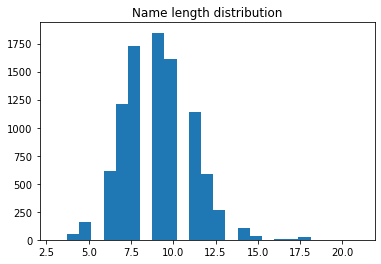

In [93]:
plt.title('Name length distribution')
plt.hist(list(map(len, names)), bins=25)

In [94]:
tokens = list(set(''.join(names)))
print(tokens)
num_tokens = len(tokens)
print('num_tokens = ', num_tokens)

['l', 'd', 'J', 't', 'D', 'H', 'P', 'Y', 'f', 'c', 's', 'b', 'C', 'u', 'k', 'U', 'B', '-', 'j', 'N', 'Z', 'w', 'O', 'F', 'y', '\xa0', 'S', ' ', ',', 'i', 'h', 'E', 'm', 'R', 'g', 'a', 'V', 'M', 'В', 'K', 'L', 'v', 'I', 'z', 'p', "'", 'n', 'e', 'r', 'A', 'o', 'G', 'T']
num_tokens =  53


In [95]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}

In [96]:
token_to_id

{'l': 0,
 'd': 1,
 'J': 2,
 't': 3,
 'D': 4,
 'H': 5,
 'P': 6,
 'Y': 7,
 'f': 8,
 'c': 9,
 's': 10,
 'b': 11,
 'C': 12,
 'u': 13,
 'k': 14,
 'U': 15,
 'B': 16,
 '-': 17,
 'j': 18,
 'N': 19,
 'Z': 20,
 'w': 21,
 'O': 22,
 'F': 23,
 'y': 24,
 '\xa0': 25,
 'S': 26,
 ' ': 27,
 ',': 28,
 'i': 29,
 'h': 30,
 'E': 31,
 'm': 32,
 'R': 33,
 'g': 34,
 'a': 35,
 'V': 36,
 'M': 37,
 'В': 38,
 'K': 39,
 'L': 40,
 'v': 41,
 'I': 42,
 'z': 43,
 'p': 44,
 "'": 45,
 'n': 46,
 'e': 47,
 'r': 48,
 'A': 49,
 'o': 50,
 'G': 51,
 'T': 52}

In [97]:
assert len(tokens) == len(token_to_id)

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i
print("OK")

OK


In [98]:
def to_matrix(data, token_dict, max_len=None, dtype='int32', batch_first=True):
    max_len = max_len or max(map(len, data))
    data_ix = np.zeros([len(data), max_len], dtype) + token_dict[' ']
    
    for i in range(len(data)):
        line_ix = [token_dict[c] for c in data[i]]
        data_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first:
        data_ix = np.transpose(data_ix)
        
    return data_ix

In [99]:
print('\n'.join(names[::2000]))
print(to_matrix(names[::2000], token_to_id))


 Ababko
 Chihachev
 Isaikov
 Nakhamkin
 Ustenko
[[27 49 11 35 11 14 50 27 27 27]
 [27 12 30 29 30 35  9 30 47 41]
 [27 42 10 35 29 14 50 41 27 27]
 [27 19 35 14 30 35 32 14 29 46]
 [27 15 10  3 47 46 14 50 27 27]]


In [100]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [133]:
class CharRNNCell(nn.Module):
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
    
    def forward(self, x, h_prev):
        x_emb = self.embedding(x)
        x_and_h = torch.cat([x_emb, h_prev], dim=1)
        h_next = self.rnn_update(x_and_h)
        
        h_next = F.tanh(h_next)
        
        logits = self.rnn_to_logits(h_next)
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        return Variable(torch.zeros(batch_size, self.num_units))

In [134]:
#EXAMPLE Variable class. Allow calculate gradient for function
import torch

from torch.autograd import Variable
x = Variable(torch.ones(2, 2) , requires_grad=True) # wrapper for torch tensor

z = 2 * (x * x) + 5 * x # 4 x + 5
z.backward(torch.ones(2, 2)) #back propagation in spot 1,1
print(x.grad)


tensor([[9., 9.],
        [9., 9.]])


In [135]:
def rnn_loop(rnn, batch_index):
    batch_size, max_length = batch_index.size()
    hid_state = rnn.initial_state(batch_size)
    logprobs = []
    
    for x_t in batch_index.transpose(0,1):
        hid_state, logp_next = rnn(x_t, hid_state)
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

In [136]:
from IPython.display import clear_output
from random import sample

char_rnn = CharRNNCell()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

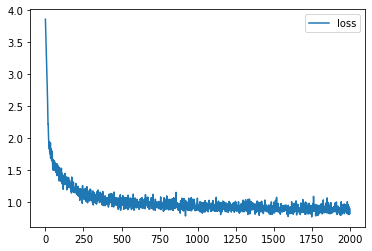

In [139]:
MAX_LENGTH = max(map(len, names))

for i in range(1000):
    batch_ix = to_matrix(sample(names, 32), token_to_id, max_len = MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype = torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]
    
    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:, :, None]))
    
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    
    if(i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didnt converge"

In [140]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
        
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=1).data.numpy()[0]
        
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])
    

In [141]:
for _ in range(10):
    print(generate_sample(char_rnn))

 Mahugin             
 Rapupov             
 Shimor              
 Katulvak            
 Turtbaiv            
 Dobikov             
 Jakishitov          
 Yabarin             
 Sheiman-a           
 Bismanov            


In [151]:
for _ in range(10):
    print(generate_sample(char_rnn, seed_phrase=' Pak'))

 Pakhonenko          
 Pakmak              
 Pakh ik             
 Pakhamov            
 Pakhankin           
 Pakhenov            
 Pakinov             
 Pakzevin            
 Pakhetachin         
 Pakmukov            
